# Unit 5 Project - Telco Churn With Boosting Models

**Brief**

In a telecomunnications dataset, the telco company would like to know which customers are likely to leave (churn). 

A plan also needs to be developed to try to keep customers from leaving/churning.

For this boosting models with classification project, I am using the Unit 2 Telco Churn dataset.

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install catboost

     |████████████████████████████████| 63.6MB 36kB/s 


In [0]:
# Imports:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import xgboost as xgb
from catboost import CatBoostClassifier

# Show all columns
pd.set_option('display.max_columns', None)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Read data in:

telco_data = pd.read_csv('/content/drive/My Drive/Telco-Customer-Churn.csv')

In [13]:
# Preview

telco_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [14]:
telco_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [16]:
telco_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

There are no NULL values.

In [64]:
telco_data.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

# Some Exploratory Data Analysis (EDA)

## Kaplan-Meier Survival Curve - Copied Mostly From Unit 2 Classification


**Same thing from Unit 2 Project**

A Kaplan-Meier survival curve from the statistical field of Survival Analysis can be used to model churns from different groups.

The groups here are Month-To-Month customers, One-Year contract customers and Two-Year contract customers.

This Kaplan-Meier survival curve looks at the people leaving (customer churn) and the remaining customers over time (tenure).

The statistical field of survival analysis involves time to event data.

* Tenure: Customer service time (months)
* Event Of Interest: Churn (Yes/ True)
* Kaplan-Meier survival curve visualization for customer churn by contract.
* Survival curve estimates the probability of the customer staying (non-churn) past a point in time.

&nbsp;

[Survival Analysis Python Reference](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html)

---

Given a customer's time with the business $C$, the survival function of a population $S(t)$ is the probability of the customer time $C$ being greater than some point in time $t$.

$$S(t) = P(C > t)$$

&nbsp;

The survival function is related to the cumulative distribution function $F(t)$. This formula holds true.

$$S(t) = 1 - F(t) = 1 - P(C \leq t)$$


In [17]:
pip install lifelines

     |████████████████████████████████| 389kB 2.8MB/s 


In [0]:
# Ref: https://lifelines.readthedocs.io/en/latest/Quickstart.html
# Ref 2: https://plot.ly/ipython-notebooks/survival-analysis-r-vs-python/
# Use lifelines library for survival analysis.

from lifelines import KaplanMeierFitter

##### Overall Churn

In [0]:
# Set variables for Kaplan-Meier survival curve:

km_time = telco_data['tenure']
km_churn = telco_data['Churn'].apply(lambda x: True if x == 'Yes' else False)

In [20]:
# Check churn_km

km_churn.head()

0    False
1    False
2     True
3    False
4     True
Name: Churn, dtype: bool

**How Many Customers Churn**

In [21]:
# Number of customers in dataset

km_churn.count()

7043

In [22]:
# 1869 out of 7043 Churn

km_churn.value_counts()

False    5174
True     1869
Name: Churn, dtype: int64

In [23]:
km_churn.value_counts(normalize = True)

False    0.73463
True     0.26537
Name: Churn, dtype: float64

There are 1869 customers who churn from the 7043 customers in the dataset. This is about 26.5 percent of 7043.

In [24]:
# Median & mean tenure:

print(f'Median tenure: {np.median(km_time)}')
print(f'Mean tenure: {np.mean(km_time)}')

Median tenure: 29.0
Mean tenure: 32.37114865824223


In [26]:
# Fit Kaplan Meier Curve

km_curve = KaplanMeierFitter()
km_curve.fit(km_time, event_observed = km_churn)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7043 total observations, 5174 right-censored observations>

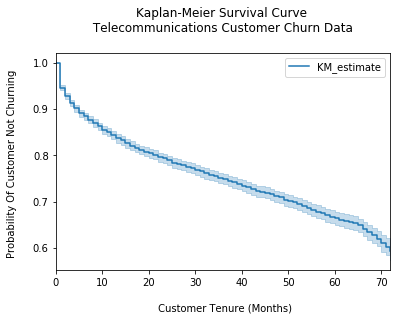

In [29]:
# Plot Of Tenure Time For All Customers

# Set style:

km_curve.survival_function_
km_curve.cumulative_density_
#km_curve.median_

km_curve.plot_survival_function() # or just kmf.plot()

# Median line:
#plt.axvline(x = np.median(time_km), color = 'green', alpha = 0.3)

# Mean line:
#plt.axvline(x = np.mean(time_km), color = 'black', alpha = 0.2)

# Look at 12 months and 24 months tenure (1 yr and 2 yr contracts)

#plt.axvline(x = 12, color = 'black', alpha = 0.2)

#plt.axvline(x = 24, color = 'black', alpha = 0.2)



plt.xlabel('\n Customer Tenure (Months)')
plt.ylabel('Probability Of Customer Not Churning \n')
plt.title('Kaplan-Meier Survival Curve \n Telecommunications Customer Churn Data \n')

plt.savefig('overallChurn.png', dpi=300, bbox_inches = "tight")

**Observations**

* It appears that after 12 months, there is a 15% chance of the customers leaving. 
* After 20 months there is a 80% chance of non-churn or a 20% chance of the customer leaving.

##### By Contract Type

In [0]:
# Filtered data for Kaplan-Meier

telco_km = telco_data[['Contract', 'tenure', 'Churn']]

In [31]:
# Check:

telco_km.tail(5)

,Contract,tenure,Churn
7038,One year,24,No
7039,One year,72,No
7040,Month-to-month,11,No
7041,Month-to-month,4,Yes
7042,Two year,66,No


In [0]:
# Filter by contract:

telco_km_mthmth = telco_km[telco_km['Contract'] == 'Month-to-month']

telco_km_oneyear = telco_km[telco_km['Contract'] == 'One year']

telco_km_twoyear = telco_km[telco_km['Contract'] == 'Two year']

**Month To Month Tenure**

In [33]:
mthmth_tenure = telco_km_mthmth['tenure']

mthmth_tenure.head()

0     1
2     2
4     2
5     8
6    22
Name: tenure, dtype: int64

In [34]:
# Number of Month To Month customers:


telco_data['Contract'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [35]:
# Change Yes and No to True & False:

churn_mthmth = telco_km_mthmth['Churn'].apply(lambda x: True if x == 'Yes' else False)

churn_mthmth.head()

0    False
2     True
4     True
5     True
6    False
Name: Churn, dtype: bool

In [36]:
mthmth_tenure.describe()

count    3875.000000
mean       18.036645
std        17.689054
min         1.000000
25%         3.000000
50%        12.000000
75%        29.000000
max        72.000000
Name: tenure, dtype: float64

In [37]:
churn_mthmth.sum()

1655

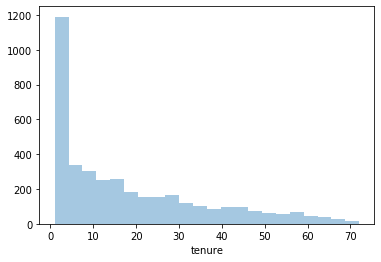

In [38]:
# Distribution Plot of month to month tenure:

sns.distplot(mthmth_tenure, kde = False)
#plt.xticks(range(0, 75, 6))

In [0]:
# Kaplan-Meier Survival Curve For Month To Month

#ax = plt.subplot(111)

#kmf_catg.fit(mthmth_tenure , churn_mthmth, label = 'Month-To-Month')
#kmf_catg.survival_function_.plot(ax=ax)
                                 
#kmf2 = plt.gcf()

In [0]:
# Obtain tenure times and Churn events from one year contracts and two year contracts:

oneyear_tenure = telco_km_oneyear['tenure']
churn_oneyear = telco_km_oneyear['Churn'].apply(lambda x: True if x == 'Yes' else False)

twoyear_tenure = telco_km_twoyear['tenure']
churn_twoyear = telco_km_twoyear['Churn'].apply(lambda x: True if x == 'Yes' else False)

In [41]:
churn_oneyear.head()

1     False
3     False
9     False
12    False
16    False
Name: Churn, dtype: bool

### Kaplan-Meier Curve For All Three Contracts - Month-To-Month Churns Most

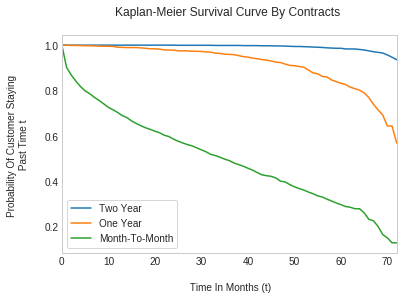

In [42]:
# Fit Kaplan Meier Curve
# Removed grid and added legend frame after presentation

# Set style:

plt.style.use('seaborn-whitegrid')

kmf_catg = KaplanMeierFitter()

ax = plt.subplot(111)

kmf_catg.fit(twoyear_tenure, churn_twoyear, label = 'Two Year')
kmf_catg.survival_function_.plot(ax=ax)

kmf_catg.fit(oneyear_tenure , churn_oneyear, label = 'One Year')
kmf_catg.survival_function_.plot(ax=ax)

kmf_catg.fit(mthmth_tenure , churn_mthmth, label = 'Month-To-Month')
kmf_catg.survival_function_.plot(ax=ax)

plt.title('Kaplan-Meier Survival Curve By Contracts \n')
plt.xlabel('\n Time In Months (t)')
plt.ylabel('Probability Of Customer Staying \n Past Time t \n')
plt.legend(frameon = True)
plt.grid()

plt.savefig('Churn_byContract.png', dpi=300, bbox_inches = "tight")

This Kaplan-Meier survival curve turned out very nicely in terms of comparing groups. It can be easily be seen that over time that month-to-month customers are more likely to leave compared to the one-year and two-year contracts.


**Month-To-Month Contracts Analysis**

* It appears that 40% of month-to-month customers do churn by the 20th month. 

* About 25% of month-to-month customers churn by the 10th month.

In [0]:
# 40% Of The Number Of Month-To-Month Customers:
# Represents number of loss customers by month 20

0.4 * 3875 

1550.0

In [0]:
# 25% Of The Number Of Month-To-Month Customers:
# Represents number of loss customers by month 10

0.25 * 3875 

968.75

In [0]:
telco_data[(telco_data['Contract'] == 'Month-to-month') & (telco_data['tenure'] > 10)].count()

customerID          2047
gender              2047
SeniorCitizen       2047
Partner             2047
Dependents          2047
tenure              2047
PhoneService        2047
MultipleLines       2047
InternetService     2047
OnlineSecurity      2047
OnlineBackup        2047
DeviceProtection    2047
TechSupport         2047
StreamingTV         2047
StreamingMovies     2047
Contract            2047
PaperlessBilling    2047
PaymentMethod       2047
MonthlyCharges      2047
TotalCharges        2047
Churn               2047
dtype: int64

In [0]:
telco_data[(telco_data['Contract'] == 'Month-to-month') & (telco_data['tenure'] <= 10)].count()

customerID          1828
gender              1828
SeniorCitizen       1828
Partner             1828
Dependents          1828
tenure              1828
PhoneService        1828
MultipleLines       1828
InternetService     1828
OnlineSecurity      1828
OnlineBackup        1828
DeviceProtection    1828
TechSupport         1828
StreamingTV         1828
StreamingMovies     1828
Contract            1828
PaperlessBilling    1828
PaymentMethod       1828
MonthlyCharges      1828
TotalCharges        1828
Churn               1828
dtype: int64

## Overall Churn Counts By Contract

Want to look at number of churns over tenure time (months) for each contract.

1. Month-To-Month (`telco_km_mthmth`)
2. One Year (`telco_km_oneyear`)
3. Two Year (`telco_km_twoyear`)

##### Month-To-Month

In [43]:
# Monthly contract customers

telco_km_mthmth.head()

,Contract,tenure,Churn
0,Month-to-month,1,No
2,Month-to-month,2,Yes
4,Month-to-month,2,Yes
5,Month-to-month,8,Yes
6,Month-to-month,22,No


In [44]:
# 1) Churned numbers for month-to-month customers

telco_monthly_churn = telco_km_mthmth[telco_km_mthmth['Churn'] == 'Yes']

telco_monthly_churn.head()

,Contract,tenure,Churn
2,Month-to-month,2,Yes
4,Month-to-month,2,Yes
5,Month-to-month,8,Yes
8,Month-to-month,28,Yes
13,Month-to-month,49,Yes


In [45]:
telco_monthly_churn.count()

Contract    1655
tenure      1655
Churn       1655
dtype: int64

In [0]:
# Month-to-month churn counts
monthly_churn_counts =  telco_monthly_churn.groupby(['tenure'])['Churn'].count()

In [47]:
# Total churn counts:

monthly_churn_counts.sum()

1655

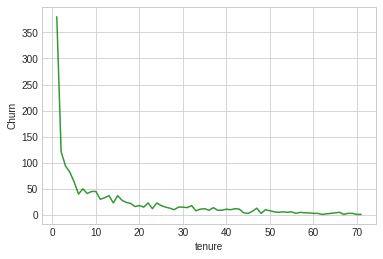

In [50]:
# Month-to-month churn plots:

sns.lineplot(x = monthly_churn_counts.index, y = monthly_churn_counts, 
             color = 'green',
             alpha = 0.8)


##### One Year Contract Customers

In [51]:
# 2) Churned numbers for one year contract customers

oneyear_churn = telco_km_oneyear[telco_km_oneyear['Churn'] == 'Yes']

oneyear_churn.head()

,Contract,tenure,Churn
173,One year,53,Yes
317,One year,38,Yes
320,One year,54,Yes
335,One year,68,Yes
495,One year,22,Yes


In [0]:
# 1 yr contract churn counts

oneyear_churn_counts =  oneyear_churn.groupby(['tenure'])['Churn'].count()

In [53]:
# Check counts:

oneyear_churn_counts.head(10)

tenure
2     2
4     1
5     1
7     1
8     1
9     1
11    1
12    5
13    1
14    1
Name: Churn, dtype: int64

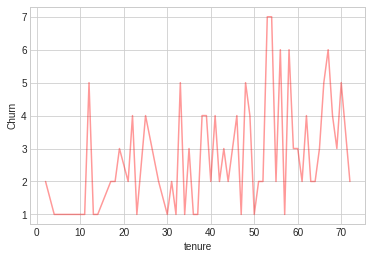

In [55]:
# One year contract churn plots:

sns.lineplot(x = oneyear_churn_counts.index, y = oneyear_churn_counts, 
             color = 'red',
             alpha = 0.4)



##### Two Year Contract Customers

In [56]:
# 3) Churned numbers for one year contract customers

twoyear_churn = telco_km_twoyear[telco_km_twoyear['Churn'] == 'Yes']

twoyear_churn.head()

,Contract,tenure,Churn
104,Two year,68,Yes
268,Two year,59,Yes
336,Two year,43,Yes
811,Two year,70,Yes
975,Two year,71,Yes


In [0]:
# 2 yr contract churn counts

twoyear_churn_counts =  twoyear_churn.groupby(['tenure'])['Churn'].count()

In [58]:
# Check:

twoyear_churn_counts.head()

tenure
25    1
33    1
39    1
43    1
46    1
Name: Churn, dtype: int64

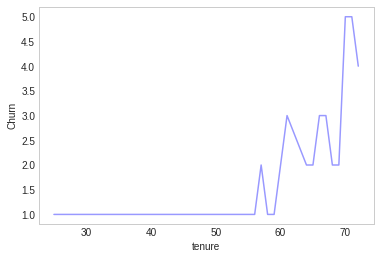

In [59]:
# Two year contract churn plots:

sns.lineplot(x = twoyear_churn_counts.index, y = twoyear_churn_counts, 
             color = 'blue',
             alpha = 0.4)

plt.grid()

##### All Three Customer Churn Plots In One

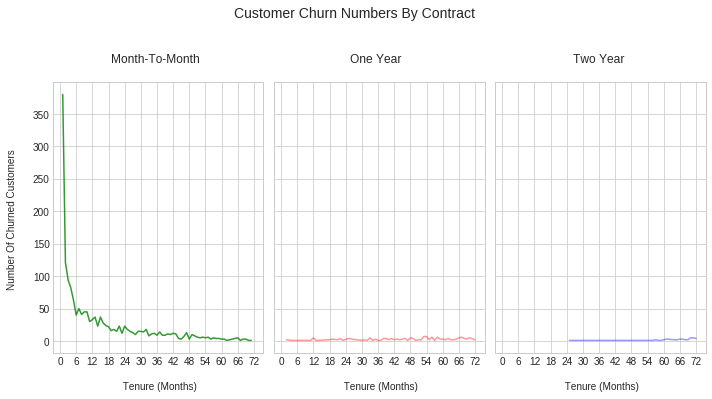

In [61]:
## A Better Plot Than The Above For Comparison

# Subplots

fig, axes = plt.subplots(figsize = (10, 5), 
                                    nrows = 1, 
                                    ncols = 3,
                                    sharex = True,
                                    sharey = True)

# fig = overall figure

# Left (ax1) plot - Month-To-Month Customer Churn

sns.lineplot(x = monthly_churn_counts.index, y = monthly_churn_counts, 
             color = 'green',
             alpha = 0.8,
             ax = axes[0])


# Center (ax2) Plot - One year contract churn numbers

sns.lineplot(x = oneyear_churn_counts.index, y = oneyear_churn_counts, 
             color = 'red',
             alpha = 0.4,
             ax = axes[1])

# Right (ax3) Plot - Two year contract churn plots:

sns.lineplot(x = twoyear_churn_counts.index, y = twoyear_churn_counts, 
             color = 'blue',
             alpha = 0.4,
             ax = axes[2])

# Vertical light blue lines to separate years:

#for i in range(3):
#  axes[i].axvline(x = '2018-01-01', linewidth=2, color='blue', alpha = 0.10)
#  axes[i].axvline(x = '2017-01-01', linewidth=2, color='blue', alpha = 0.10)
#  axes[i].axvline(x = '2016-01-01', linewidth=2, color='blue', alpha = 0.10)

# Set titles:

axes[0].set_title('Month-To-Month  \n')

axes[1].set_title('One Year  \n')

axes[2].set_title('Two Year \n')

# y-axis Label:

axes[0].set_ylabel("Number Of Churned Customers \n")

# x-axis labels for labelling and rotation:
# https://stackoverflow.com/questions/31186019/rotate-tick-labels-in-subplot-pyplot-matplotlib-gridspec

for j in range(3):
  axes[j].set_xlabel('\n Tenure (Months)')

# Main title:
plt.suptitle('Customer Churn Numbers By Contract \n', 
             size = 14, 
             y = 1.10)

plt.tight_layout()

# x-ticks:

plt.xticks(np.arange(0, 74, step = 6))

# Save figure:

plt.autoscale()
plt.savefig('churnCounts_contract.png', dpi=300, bbox_inches = "tight")

plt.show()

# Data Preprocessing

In [62]:
telco_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [68]:
list(telco_data.columns)

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [71]:
len(list(telco_data.columns))

21

In [70]:
# Remove Churn and customerID columns from columns list (experiment):

list(set(telco_data.columns) - set(['Churn', 'customerID']))

['Partner',
 'StreamingMovies',
 'PaperlessBilling',
 'OnlineSecurity',
 'gender',
 'PaymentMethod',
 'InternetService',
 'SeniorCitizen',
 'Contract',
 'PhoneService',
 'TotalCharges',
 'OnlineBackup',
 'MultipleLines',
 'DeviceProtection',
 'TechSupport',
 'Dependents',
 'StreamingTV',
 'tenure',
 'MonthlyCharges']

In [0]:
# Select variables:

X_cols = list(set(telco_data.columns) - set(['Churn', 'customerID']))

y_col = ['Churn']

In [74]:
len(X_cols)

19

In [0]:
# Make a copy for transformed data:

telco_data_tf = telco_data.copy()

Label encoders will be used to convert text values into numeric values.

In [0]:
# Create empty dictionary:

encoders = {}

In [0]:
# Encode X_columns with a for loop

for xcol in X_cols:
  if df[column].dtype != pd.np.object: # Strings considered to be objects in Numpy module
    continue
  # Fitting inidividual Label Encoders
  le = preprocessing.LabelEncoder() 
  le.fit(df[column].values)
  df_transformed[column] = le.transform(df[column])
  # Add label encoder into dictionary
  encoders[column] = le

In [0]:
encoders

In [0]:
telco_data_tf.head()

# Ensemble Methods For Classification

In [0]:
# Train Test Split

## 1) Random Forest

## 2) Adaboost

## 3) Xtreme Gradient Boosting (XGBoost)

## 4) CatBoost

## Comparing Metric Scores (Recall)